# Preprocessing

This notebook is used for the exploratory data analysis and preprocessing of the heart disease dataset of the UCI Machine Learning Repository

## Import Data

In [1]:
import pandas as pd

# Load the dataset
data = pd.read_csv('./Data/processed.cleveland.data', header=None)
data.shape

(303, 14)

## Preprocessing

### Specify column names based on UCI repository documentation


In [2]:
data.columns = [ 
    'age',          # age in years
    'sex',          # sex (1 = male; 0 = female)
    'cp',           # chest pain type (1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic)
    'trestbps',     # resting blood pressure (in mm Hg on admission to the hospital)
    'chol',         # serum cholestoral in mg/dl
    'fbs',          # (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
    'restecg',      # resting electrocardiographic results (0: normal, 1: having ST-T wave abnormality, 2: showing probable or definite left ventricular hypertrophy)
    'thalach',      # maximum heart rate achieved
    'exang',        # exercise induced angina (1 = yes; 0 = no)
    'oldpeak',      # ST depression induced by exercise relative to rest
    'slope',        # the slope of the peak exercise ST segment
    'ca',           # number of major vessels (0-3) colored by flourosopy
    'thal',         # 3 = normal; 6 = fixed defect; 7 = reversible defect
    'target'        # diagnosis of heart disease. Presence (values 1,2,3,4) or absence (value 0) of heart disease
]

### Treat missing values

Only two variables have missing values. Moreover, this missing values only affect 6 out of the 303 samples.

We decide to input the variables by making a clustering via K-means and assigning the most common value in its cluster.

For the 'ca' column, all 4 inputed values where 0.

For the 'thal' column, imputed values where assigned to the 3.0 value.


In [3]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# Detect which columns have missing values represented by '?', and count them
missing_value = data.columns[data.isin(['?']).any()]
na_value_columns = data.columns[data.isna().any()]
# Join both lists
missing_value_columns = missing_value.union(na_value_columns)

for col in missing_value_columns:
    missing_count = data[col].isin(['?']).sum()
    missing_count += data[col].isna().sum()
    print(f"Column '{col}' has {missing_count} missing values")
    # Use np.nan instead of pd.NA for sklearn compatibility
    data[col] = data[col].replace('?', np.nan)

# Print the IDs of rows with missing values
rows_with_missing = data[data.isna().any(axis=1)]
print("Rows with missing values:")
print(rows_with_missing.index.tolist())

# Get summary statistics of the columns with missing values
for col in missing_value_columns:
    print(f"Value counts for column '{col}':")
    print(data[col].value_counts(dropna=False))
    print()

# Create a clustering by dropping the target variable and impute missing values
imputer = SimpleImputer(strategy='most_frequent')
kmeans = KMeans(n_clusters=3, random_state=0)

# Drop target variable for clustering
data_no_target = data.drop(columns=['target'])

# Convert to numeric if needed (for clustering to work properly)
# If you have categorical columns, you may need to encode them first
data_no_target_numeric = data_no_target.copy()
for col in data_no_target_numeric.columns:
    if data_no_target_numeric[col].dtype == 'object':
        # Simple label encoding for clustering
        data_no_target_numeric[col] = pd.Categorical(data_no_target_numeric[col]).codes

# Fit and transform with imputer
data_no_target_imputed = imputer.fit_transform(data_no_target_numeric)

# Fit KMeans
kmeans.fit(data_no_target_imputed)

# Assign clusters
data['cluster'] = kmeans.labels_

# Impute missing values within each cluster
for col in missing_value_columns:
    for cluster in data['cluster'].unique():
        cluster_mask = data['cluster'] == cluster
        cluster_data = data.loc[cluster_mask, col]
        
        # Get the most frequent value in this cluster (excluding NaN)
        if cluster_data.notna().any():
            most_frequent = cluster_data.mode()
            if len(most_frequent) > 0:
                # Fill missing values with the most frequent value in the cluster
                data.loc[cluster_mask & data[col].isna(), col] = most_frequent.iloc[0]

# If any missing values remain (e.g., entire cluster was missing), fill with global mode
for col in missing_value_columns:
    if data[col].isna().any():
        global_mode = data[col].mode()
        if len(global_mode) > 0:
            data[col].fillna(global_mode.iloc[0], inplace=True)

# Drop the cluster column
data = data.drop(columns=['cluster'])


#convert columns to numeric again
for col in data.columns:
    data[col] = pd.to_numeric(data[col])

Column 'ca' has 4 missing values
Column 'thal' has 2 missing values
Rows with missing values:
[87, 166, 192, 266, 287, 302]
Value counts for column 'ca':
ca
0.0    176
1.0     65
2.0     38
3.0     20
NaN      4
Name: count, dtype: int64

Value counts for column 'thal':
thal
3.0    166
7.0    117
6.0     18
NaN      2
Name: count, dtype: int64



In [4]:
# Columns 'ca' and 'thal' had missing values. Check thir counts now
print(data[['ca']].value_counts(dropna=False)) 
print(data[['thal']].value_counts(dropna=False)) 

ca 
0.0    180
1.0     65
2.0     38
3.0     20
Name: count, dtype: int64
thal
3.0     168
7.0     117
6.0      18
Name: count, dtype: int64


### Outlier treatment

After detecting and plotting the distributions of the outliers, we decide the following:

Keep them like they were:
- cp column: All samples with value 0.693147 are marked as outliers (23).
- fb column: The same but with 6 outliers.

Transform them because outliers are values that are apart from the distributions.
- thalach: Applying a box-cox transformation removes the outliers
- trestbps, chol: log and box cox transformation don't remove the outliers, so we proceed to remove them (since there are only 14 samples)


Column 'cp' has 23 outliers.


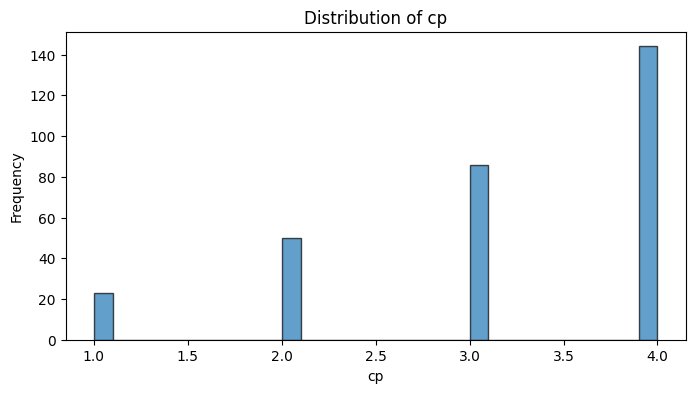

      cp
0    1.0
20   1.0
21   1.0
27   1.0
30   1.0
41   1.0
59   1.0
101  1.0
112  1.0
124  1.0
141  1.0
150  1.0
182  1.0
183  1.0
196  1.0
199  1.0
211  1.0
215  1.0
243  1.0
262  1.0
274  1.0
275  1.0
298  1.0
Column 'trestbps' has 9 outliers.


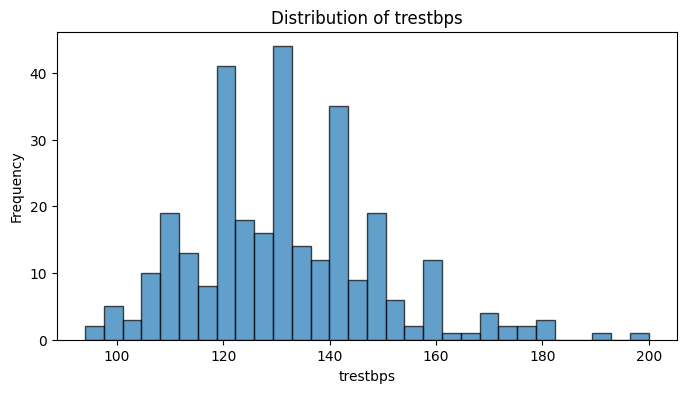

     trestbps
14      172.0
83      180.0
126     200.0
172     174.0
183     178.0
188     192.0
201     180.0
213     178.0
231     180.0
Column 'chol' has 5 outliers.


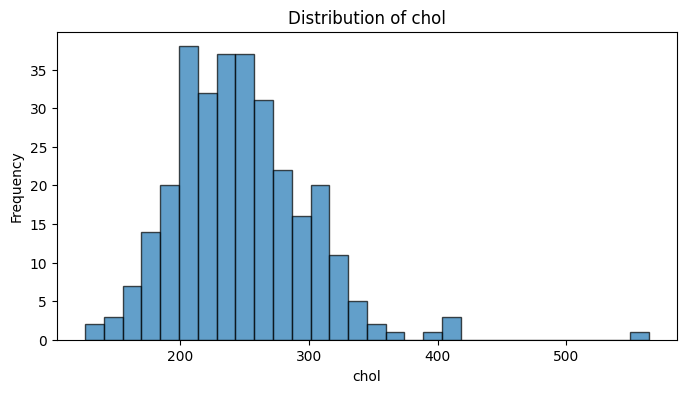

      chol
48   417.0
121  407.0
152  564.0
173  394.0
181  409.0
Column 'fbs' has 45 outliers.


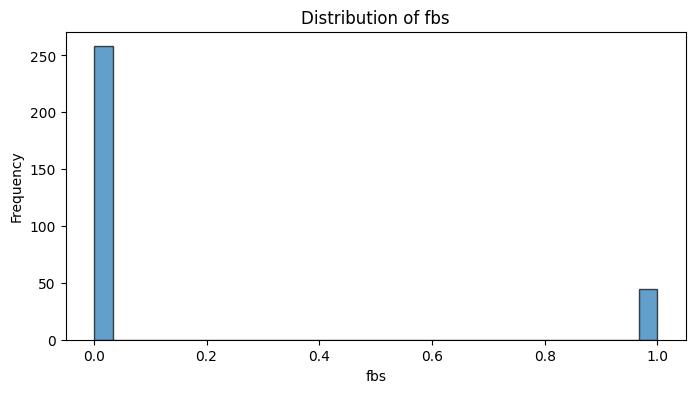

     fbs
0    1.0
9    1.0
12   1.0
14   1.0
21   1.0
31   1.0
39   1.0
43   1.0
48   1.0
49   1.0
63   1.0
71   1.0
83   1.0
103  1.0
111  1.0
113  1.0
116  1.0
118  1.0
120  1.0
124  1.0
126  1.0
139  1.0
142  1.0
146  1.0
150  1.0
160  1.0
164  1.0
167  1.0
176  1.0
179  1.0
186  1.0
192  1.0
193  1.0
196  1.0
202  1.0
213  1.0
236  1.0
244  1.0
249  1.0
261  1.0
266  1.0
267  1.0
286  1.0
296  1.0
299  1.0
Column 'thalach' has 1 outliers.


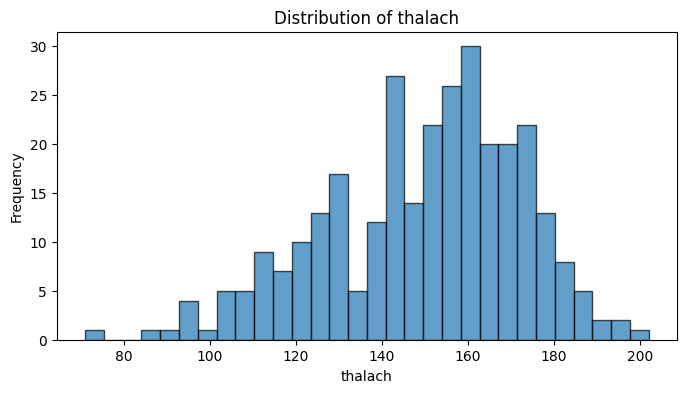

     thalach
245     71.0
Column 'oldpeak' has 5 outliers.


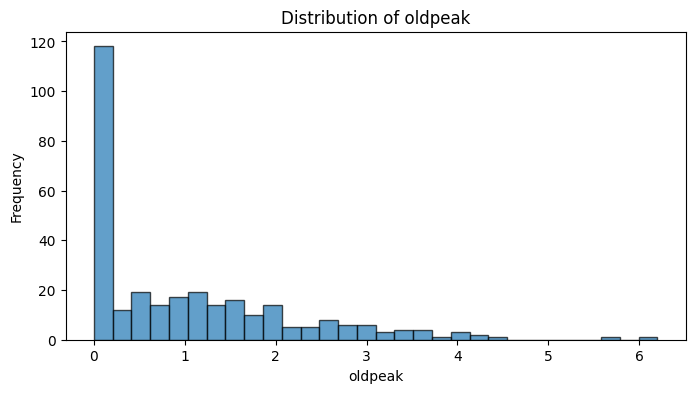

     oldpeak
91       6.2
123      5.6
183      4.2
191      4.2
285      4.4
Column 'ca' has 20 outliers.


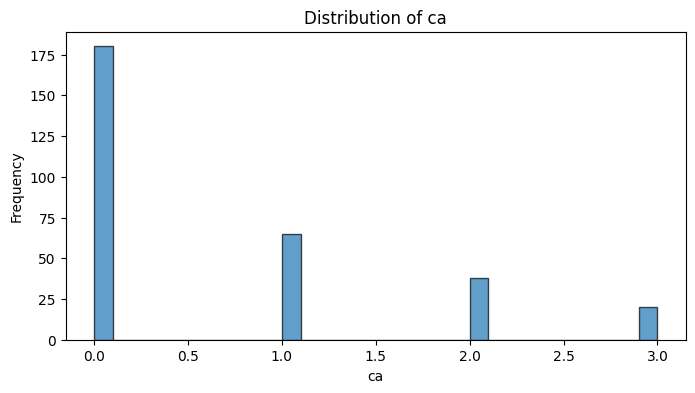

      ca
1    3.0
40   3.0
62   3.0
91   3.0
92   3.0
104  3.0
118  3.0
121  3.0
146  3.0
155  3.0
161  3.0
176  3.0
179  3.0
187  3.0
189  3.0
191  3.0
193  3.0
205  3.0
232  3.0
285  3.0


In [5]:
numerical_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Detect columns with outliers and plot their distributions
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    if outliers.shape[0] > 0:
        print(f"Column '{col}' has {outliers.shape[0]} outliers.")
    
        #plot distribution
        import matplotlib.pyplot as plt
        plt.figure(figsize=(8, 4))
        plt.hist(data[col], bins=30, edgecolor='k', alpha=0.7)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
        # print the outlier values
        print(outliers[[col]])

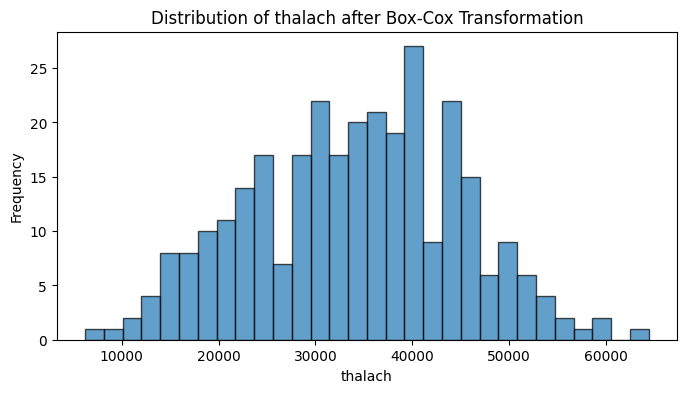

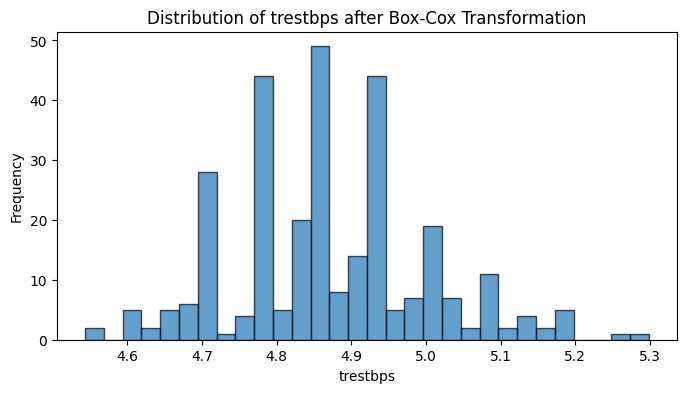

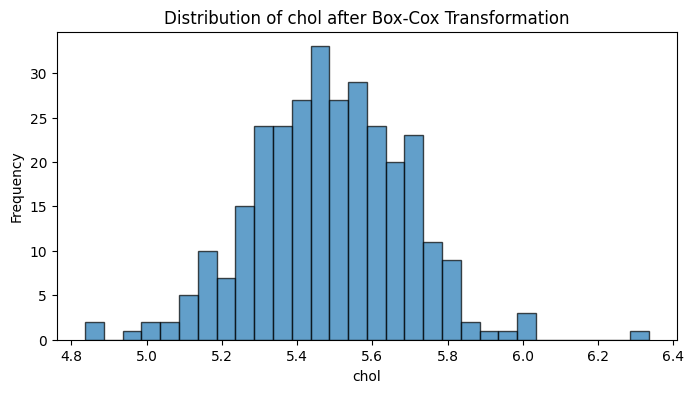

After transformation, column 'cp' has 23 outliers.
After transformation, column 'trestbps' has 9 outliers.
After transformation, column 'chol' has 5 outliers.
After transformation, column 'fbs' has 45 outliers.
After transformation, column 'oldpeak' has 5 outliers.
After transformation, column 'ca' has 20 outliers.


In [6]:
# transform the columns thalach, trestbps, chol using BOX-Cox from the transformation
from scipy import stats
for col in ['thalach']:
    # Box-Cox requires all positive values
    if (data[col] <= 0).any():
        print(f"Column '{col}' has non-positive values, cannot apply Box-Cox.")
        continue
    transformed_data, _ = stats.boxcox(data[col])
    data[col] = transformed_data

# for the others two columns, we can use log transformation
for col in ['trestbps', 'chol']:
    # Log transformation requires all positive values
    if (data[col] <= 0).any():
        print(f"Column '{col}' has non-positive values, cannot apply log transformation.")
        continue
    data[col] = np.log(data[col])

# Print the plots again to see the effect of the transformation
for col in ['thalach', 'trestbps', 'chol']:
    plt.figure(figsize=(8, 4))
    plt.hist(data[col], bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {col} after Box-Cox Transformation')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

# Check remaining outliers after transformation
for col in numerical_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    if outliers.shape[0] > 0:
        print(f"After transformation, column '{col}' has {outliers.shape[0]} outliers.")
        

In [7]:
#remove outliers in trestbps and chol
for col in ['trestbps', 'chol']:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

### Feature scaling

We deliberately retained predictor variables in their original measurement scales to maximize clinical interpretability. In the context of heart disease prediction, model coefficients must be communicable to medical practitioners and patients who reason in familiar units: years for age, mg/dl for cholesterol, mm Hg for blood pressure. For example, a coefficient $\beta_{\text{age}} = 0.05$ directly indicates that each additional year of age increases disease odds by $\exp(0.05) \approx 5.1\%$, a clinically actionable interpretation.

Standardizing would require coefficients to be expressed per standard-deviation change (e.g., "per 10-year increase in age"), obscuring the natural per-unit effects. Importantly, logistic regression predictions are scale-invariant: the predicted probabilities $P(Y=1|X)$ remain identical regardless of standardization, as the transformation only affects parameterization, not the decision boundary. Since our primary goals are accurate risk prediction and transparent clinical interpretation retaining original scales serves these objectives without sacrificing predictive performance.

While standardization can accelerate IRLS convergence, our implementation converged reliably with no numerical issues. The minor computational cost is outweighed by interpretability gains essential for clinical decision support tools, where regulatory requirements and patient communication demand transparent, explainable models in clinically meaningful units.

### Encoding Categorical Variables

Our custom logistic regression implementation requires manually one-hot encoding each categorical variable. For a categorical feature with *k* levels, we create *k-1* binary dummy variables and use the first level as the reference category to avoid multicollinearity.
For example, the chest-pain variable (`cp`), which has four levels, becomes `cp_2`, `cp_3`, and `cp_4`. Each coefficient represents the log-odds ratio relative to the reference level `cp_1`.

The `feature_groups` parameter maps each categorical feature to the set of dummy variables it expands into (for example: `"cp": ["cp_2", "cp_3", "cp_4"]`). This allows the `step()` function to perform variable selection at the feature level. Instead of selecting or dropping individual dummy columns, the entire group is treated as a single conceptual predictor. This keeps the model interpretable and aligns the behavior with R’s `glm()`, where factor variables are automatically encoded and selected as complete units.

**R Implementation**
When working in R, categorical variables should be left as factors rather than manually creating dummy variables, since R handles contrast coding internally. For example:

* Convert `cp` to a factor.
* Fit the model using `glm()` with a binomial family.

R will report coefficients for `cp2`, `cp3`, and `cp4`, which correspond directly to the dummy variables used in our Python implementation. Both approaches treat categorical variables as unified predictors during stepwise selection, ensuring consistent model behavior across platforms.


In [8]:
# Create two different datasets, one for CustomLogisticRegression and other for R's glm
data_clr = data.copy()
data_glm = data.copy()

# In the python implementation, we will one-hot encode the categorical variables manually
categorical_cols = ['cp', 'sex','fbs', 'restecg', 'exang', 'slope', 'thal']

# Create the one-hot encoding for CustomLogisticRegression
data_clr = pd.get_dummies(data_clr, columns=categorical_cols, drop_first=True)

# In R's glm, we can keep the categorical variables as they are
# Ensure they are of type 'category'
for col in categorical_cols:
    data_glm[col] = data_glm[col].astype('category')
# Save the datasets to CSV files
data_clr.to_csv('./Data/processed_cleveland_python.csv', index=False)
data_glm.to_csv('./Data/processed_cleveland_r.csv', index=False)

### Feature Selection/Extraction

We did not apply any feature selection/extraction process, since our objective is to perform it via the step() method that we implemented.